In [2]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import pymc3 as pm
from IPython.core.pylabtools import figsize
from tqdm.notebook import tqdm
from typing import List
import itertools
import arviz

import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

# Import common utils code
%run utils/experiments.py
%run utils/bayes.py

In [3]:
cache_prefix = f'{pathlib.Path().absolute()}/cache/'
cache_prefix

'/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/latent-learning-for-anticipatory-classifier-systems-in-discretized-real-valued-environments/cache/'

## Compute populations
All algorithms will be run one more time to create a final list of population

In [4]:
%%time

# LCS helpers
def simple_maze_knowledge(pop, env):
    # dummy
    return 0


def simple_maze_metrics_collect(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': simple_maze_knowledge(population, env),
        'generalization': generalization_score(population)
    }


def run_simple_maze(trials_explore, trials_exploit):
    # noinspection PyUnresolvedReferences
    import gym_yacs_simple_maze

    simple_maze = gym.make('SimpleMaze-v0')
    simple_maze_perceptions = simple_maze.env.PERCEPTIONS

    # DynaQ helpers
    def simple_maze_perception_to_int(p0):
        p0m = list(map(int, p0))
        return list(simple_maze_perceptions.keys())[list(simple_maze_perceptions.values()).index(p0m)]

    def simple_maze_knowledge_calculator(model, env):
        # dummy
        return 0

    common_params = {
        'env': simple_maze,
        'observation_wrapper': None,
        'classifier_length': 4,
        'possible_actions': 4,
        'learning_rate': 0.1,
        'metrics_trial_freq': 1,
        'metrics_fcn': simple_maze_metrics_collect,
        'trials': trials_explore
    }

    acs_params = {}
    acs2_params = {'do_ga': False, 'initial_q': 0.5}
    acs2_oiq_params = {'do_ga': False, 'initial_q': 0.8}
    acs2_ga_params = {'do_ga': True, 'initial_q': 0.5}
    acs2_ga_oiq_params = {'do_ga': True, 'initial_q': 0.8}

    yacs_params = {
        'trace_length': 3,
        'estimate_expected_improvements': False,
        'feature_possible_values': [{'0', '1'}] * 4
    }

    dynaq_params = {
        'q_init': np.zeros((len(simple_maze_perceptions), 4)),
        'model_init': {},
        'perception_to_state_mapper': simple_maze_perception_to_int,
        'knowledge_fcn': simple_maze_knowledge_calculator,
        'epsilon': 0.5
    }

    # explore phase
    explore_result = run_experiment_parallel(common_params,
                                             acs_params=acs_params,
                                             acs2_params=acs2_params,
                                             acs2_oiq_params=acs2_oiq_params,
                                             acs2_ga_params=acs2_ga_params,
                                             acs2_ga_oiq_params=acs2_ga_oiq_params,
                                             yacs_params=yacs_params,
                                             dynaq_params=dynaq_params)

    # exploit phase
    common_params['trials'] = trials_exploit
    acs_params['init_population'] = explore_result[0]['acs'].get_population()

    acs2_params['init_population'] = explore_result[0]['acs2'].get_population()
    acs2_oiq_params['init_population'] = explore_result[0]['acs2_oiq'].get_population()
    acs2_ga_params['init_population'] = explore_result[0]['acs2_ga'].get_population()
    acs2_ga_oiq_params['init_population'] = explore_result[0]['acs2_ga_oiq'].get_population()

    yacs_params['init_population'] = explore_result[0]['yacs'].get_population()
    yacs_params['init_desirability_values'] = explore_result[0]['yacs'].desirability_values

    dynaq_params['q_init'] = explore_result[0]['dynaq'][0]
    dynaq_params['model_init'] = explore_result[0]['dynaq'][1]
    dynaq_params['epsilon'] = 1.0

    exploit_result = run_experiment_parallel(common_params,
                                             acs_params=acs_params,
                                             acs2_params=acs2_params,
                                             acs2_oiq_params=acs2_oiq_params,
                                             acs2_ga_params=acs2_ga_params,
                                             acs2_ga_oiq_params=acs2_ga_oiq_params,
                                             yacs_params=yacs_params,
                                             dynaq_params=dynaq_params)

    return explore_result, exploit_result

# simple_maze_explore, simple_maze_exploit = run_simple_maze(250, 100)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.63 µs


In [5]:
df = pd.DataFrame(columns=['agent', 'trial_steps'])

for i in tqdm(range(0, 20), desc='Run'):
    _, exploit_output = run_simple_maze(250, 50)
    metrics_df = exploit_output[1].reset_index()
    df = pd.concat([df, metrics_df[['agent', 'trial_steps']]])

Run: 100%|██████████| 20/20 [06:28<00:00, 19.41s/it]


# Bayesian estimation of performance

The null hypothesis is that the performance of two classifiers is practically the same. To either accept or reject it the  ROPE and HDI intervals will be used.

## Go with all combinations

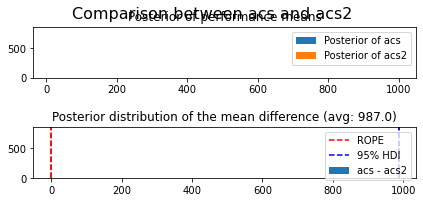

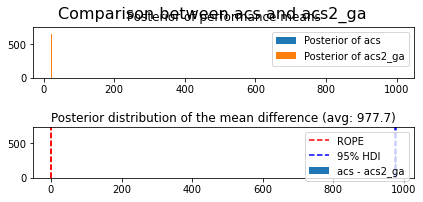

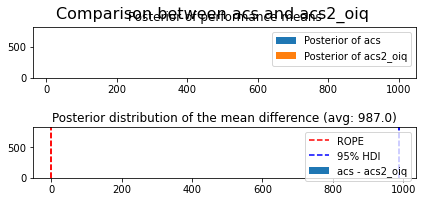

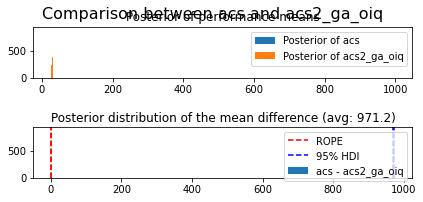

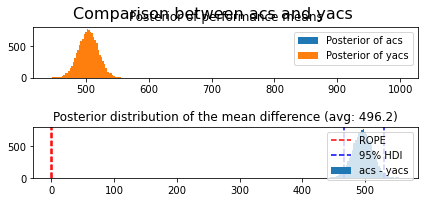

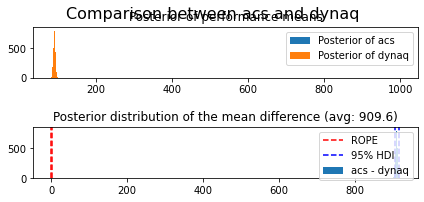

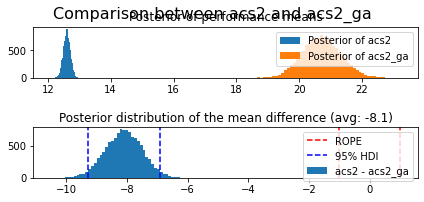

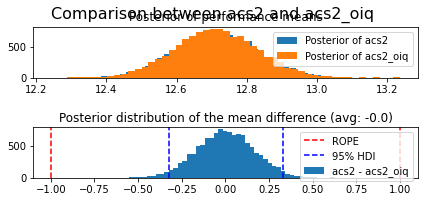

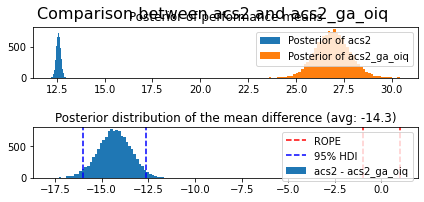

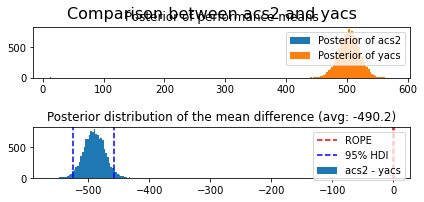

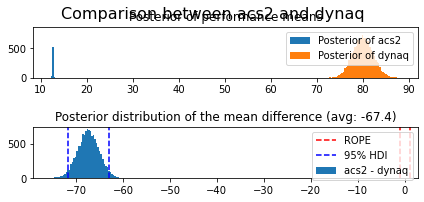

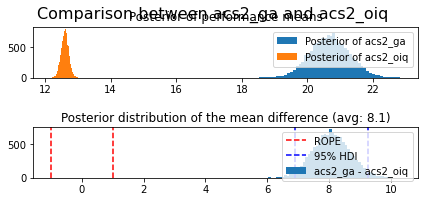

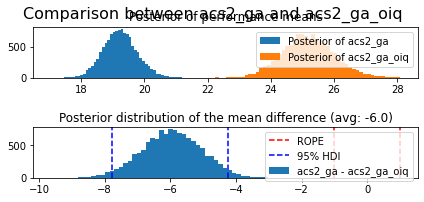

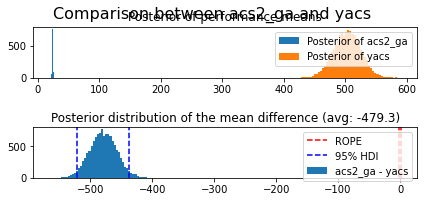

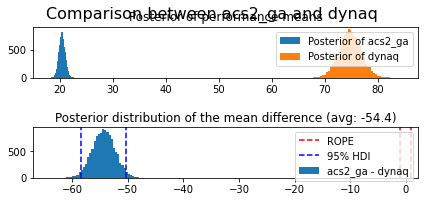

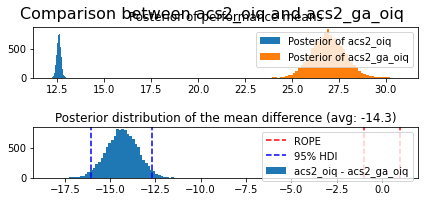

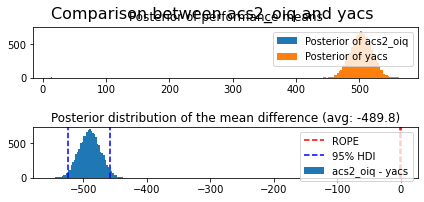

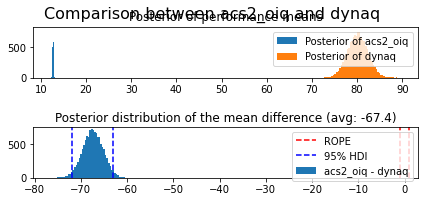

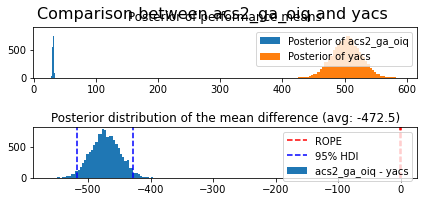

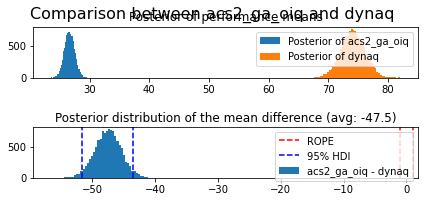

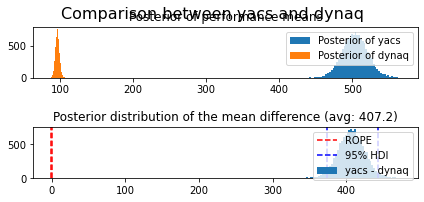

In [6]:
figsize(12, 12)
algs = ['acs', 'acs2', 'acs2_ga', 'acs2_oiq', 'acs2_ga_oiq', 'yacs', 'dynaq']

summary = []

for cl1, cl2 in itertools.combinations(algs, 2):
    trace = compare_two_classifiers(df, cl1, cl2)
    rope, hdi = visualize(trace, cl1, cl2)
    summary.append({
        'model1': cl1,
        'model2': cl2,
        'model1_avg_steps': trace['mu_1'].mean(),
        'model2_avg_steps': trace['mu_2'].mean(),
        'diff': trace['mu_1'].mean() - trace['mu_2'].mean(),
        'hdi_95': hdi,
        'h0': inference(rope, hdi)
    })

In [ ]:
pd.DataFrame(summary)